In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
import torchvision.utils as vutils
import itertools

import os
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

# Model

In [2]:
class MyModel(nn.Module):
    def __init__(self,latent_dim,nClusters):
        super(MyModel,self).__init__()

        self.latent_dim = latent_dim
        self.nClusters = nClusters
        self.pi_=nn.Parameter(torch.FloatTensor(self.nClusters,).fill_(1)/self.nClusters,requires_grad=True)
        self.mu_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)
        self.log_var_c=nn.Parameter(torch.FloatTensor(self.nClusters,self.latent_dim).fill_(0),requires_grad=True)

        self.mu = nn.Linear(256,latent_dim)
        self.logvar = nn.Linear(256,latent_dim)

        self.fc4 = nn.Linear(latent_dim, 256)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.encoder = nn.Sequential(
            nn.Linear(784,2000),
            nn.ReLU(),
            nn.Linear(2000,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,256),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(256,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,2000),
            nn.ReLU(),
            nn.Linear(2000,784),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h= self.encoder(x)
        return self.mu(h), self.logvar(h)

    def decode(self, z):
        h3 = self.relu(self.fc4(z))
        return self.decoder(h3)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
          # num = np.array([[ 1.096506  ,  0.3686553 , -0.43172026,  1.27677995,  1.26733758,
          #       1.30626082,  0.14179629,  0.58619505, -0.76423112,  2.67965817]], dtype=np.float32)
          # num = np.repeat(num, mu.size()[0], axis=0)
          # eps = Variable(torch.from_numpy(num))
        return eps.mul(std).add_(mu)
    
    def gaussian_pdf_log(self,x,mu,log_sigma2):
        return -0.5*(torch.sum(np.log(np.pi*2)+log_sigma2+(x-mu).pow(2)/torch.exp(log_sigma2),1))

    def gaussian_pdfs_log(self,x,mus,log_sigma2s):
    #def gaussian_pdfs_log(x,mus,log_sigma2s):
        G=[]
        for c in range(self.nClusters):
            G.append(self.gaussian_pdf_log(x,mus[c:c+1,:],log_sigma2s[c:c+1,:]).view(-1,1))
        return torch.cat(G,1)

    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x.view(-1,784))
        #decoded = self.decode(mu)
        z = self.reparameterize(mu,logvar)
        #z = torch.randn_like(mu)*torch.exp(logvar/2)+mu
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar

    def pre_train(self,dataloader,outdir,pre_epoch=10):
        loss=nn.MSELoss()
        optimizer = optim.Adam(itertools.chain(self.encoder.parameters(),self.decoder.parameters()))
        for epoch in tqdm(range(pre_epoch)):
            L=0
            for i, (data,y) in enumerate(dataloader):
                x=data.cuda()
                x = x.view(-1,784)
                z,_ = self.encode(x)
                x_ = self.decode(z)

                Loss = loss(x,x_)
                L += Loss.detach().cpu().numpy()

                optimizer.zero_grad()
                Loss.backward()
                optimizer.step()
        #print('epoch : ',epoch,'Loss : ',L)
        self.logvar.load_state_dict(self.mu.state_dict())

        Z=[]
        Y=[]
        with torch.no_grad():
            for i, (data,y) in enumerate(dataloader):
                data = data.view(-1,784).cuda()

                z1, z2 = self.encode(data)
                assert nn.functional.mse_loss(z1,z2)==0
                Z.append(z1)
                Y.append(y)

        Z=torch.cat(Z,0).detach().cpu().numpy()
        Y=torch.cat(Y,0).detach().numpy()
        
        gmm = GaussianMixture(n_components=self.nClusters,covariance_type='diag')

        pre = gmm.fit_predict(Z)

        self.pi_.data = torch.from_numpy(gmm.weights_).cuda().float()
        self.mu_c.data = torch.from_numpy(gmm.means_).cuda().float()
        self.log_var_c.data = torch.log(torch.from_numpy(gmm.covariances_).cuda().float())

        torch.save(self.state_dict(), outdir + '/pretrained.pth')

    def predict(self,x):
        z_mu, z_sigma2_log = self.encode(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        pi = self.pi_
        log_sigma2_c = self.log_var_c
        mu_c = self.mu_c
        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_sigma2_c))

        yita=yita_c.detach().cpu().numpy()
        #print(yita)
        return np.argmax(yita,axis=1)
        
    def RE(self,recon_x,x):
        return torch.nn.functional.binary_cross_entropy(recon_x.view(-1,784),x.view(-1,784),size_average=False)

    def KLD(self,mu,log_var):
        det=1e-10

        pi=self.pi_
        log_var_c = self.log_var_c
        mu_c = self.mu_c

        z = torch.randn_like(mu) * torch.exp(log_var/2) + mu

        yita_c = torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_var_c))+det
        yita_c = yita_c/(yita_c.sum(1).view(-1,1))
        loss = 0.5*torch.mean(torch.sum(yita_c*torch.sum(log_var_c.unsqueeze(0)+
                                                    torch.exp(log_var.unsqueeze(1)-log_var_c.unsqueeze(0))+
                                                    (mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2),1))
        loss -= torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+log_var,1))
        return loss

    def loss_function(self,recon_x,x,mu,log_var):
        return self.RE(recon_x,x)+self.KLD(mu,log_var)

In [3]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if torch.cuda.is_available():
            data = data.cuda()

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        #print(loss.data)
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

#    if epoch % 5 == 0:
#        torch.save(model.state_dict(),args.outdir+'/model_%d.pth' % (epoch))
    return (train_loss/len(train_loader.dataset)).cpu()

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar).data
        if i == 0:
            n = min(data.size(0), 16)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch, 1, 28, 28)[:n]])
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss.cpu()

# Input Parameter

In [4]:
latent_dim = 10
nClusters = 13
epoch = 300
batch = 100
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available else {}

# DataLoader

In [5]:
import h5py

In [6]:
#data_list = ['../data/normal_dataset.h5']
data_list = ['../data/normal_dataset.h5','../data/Anomaly_dataset.h5']

In [7]:
imageList=[]
labelList=[]
for file_path in data_list:
    print('Loading data from ', file_path)
    dataset = h5py.File(file_path,'r',libver='latest',swmr=True)
    FimageList=[]
    FlabelList=[]
    for gName,group in dataset.items():
        for dName,data in group.items():
            if dName == 'images':
                FimageList.append(data)
            elif dName == 'labels':
                FlabelList.append(data)

    if len(FimageList) >= 2:
        #print("More than 2 gropus in File")
        image_concat = []
        for i in range(0,len(FimageList)):
            image_concat.append(FimageList[i][:])
        imageList.append(np.concatenate(image_concat))
        label_concat = []
        for i in range(0,len(FlabelList)):
            label_concat.append(FlabelList[i][:])
        labelList.append(np.concatenate(label_concat))
    else:
        imageList.append(FimageList[0][:])
        labelList.append(FlabelList[0][:])
imageList = np.concatenate(imageList)
labelList = np.concatenate(labelList)
print('input image shape : ',imageList.shape)
print('input label shape : ',labelList.shape)
ds = TensorDataset(torch.tensor(imageList),torch.tensor(labelList))
length = [int(len(ds)*0.7),int(len(ds)*0.2)]
length.append(len(ds)-sum(length))

trnSet,valSet,tstSet=torch.utils.data.random_split(ds,length)

#train Loader
train_loader = DataLoader(trnSet, batch_size=batch, shuffle=True, **kwargs)
#test Loader
test_loader = DataLoader(valSet, batch_size=batch, shuffle=False, **kwargs)

Loading data from  ../data/normal_dataset.h5
Loading data from  ../data/Anomaly_dataset.h5
input image shape :  (72100, 1, 28, 28)
input label shape :  (72100,)


# Model pre-training (GMM initialization)

In [8]:
net = MyModel(latent_dim=latent_dim,nClusters=nClusters)

In [9]:
model = net.cuda()

In [10]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
                      0.0769, 0.0769, 0.0769, 0.0769], device='cuda:0')),
             ('mu_c',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                     

In [11]:
#model.pre_train(train_loader,'./',50)

In [12]:
model.load_state_dict(torch.load('./pretrained.pth'))

<All keys matched successfully>

In [13]:
model.state_dict()

OrderedDict([('pi_',
              tensor([0.0503, 0.0795, 0.1453, 0.0675, 0.0805, 0.0615, 0.0943, 0.0825, 0.0954,
                      0.0529, 0.0783, 0.0358, 0.0762], device='cuda:0')),
             ('mu_c',
              tensor([[ 0.3269,  0.2423, -1.1767,  0.1265, -1.6411, -0.0514,  1.2680,  0.1552,
                       -1.0933, -1.6920],
                      [-1.5452,  0.6284, -0.5518, -0.6417, -0.0115, -0.8716, -1.8359, -1.1344,
                        0.1371,  1.0210],
                      [-0.5501,  0.6253,  0.0105,  0.1014,  0.2538, -0.6938,  0.4228, -0.3846,
                       -1.0669,  0.3798],
                      [ 0.1321,  0.9404, -0.0962,  0.2376, -0.1045,  1.5160, -0.8215, -0.5496,
                       -0.5484, -0.2692],
                      [ 0.3314,  1.3884, -0.9470,  0.0056, -0.9335, -0.1818, -0.5130, -0.4348,
                       -0.6904,  0.1639],
                      [ 0.7043, -0.2167, -1.7009, -0.4411, -0.3225, -0.2091,  0.9995,  0.1459,
         

# Model Training

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
#best_=100
#for i in range(1,epoch+1):
    #trn_loss = train(i)
    #val_loss = test(i)
    #if val_loss.cpu() < best_:
        #best_ = val_loss.cpu()
        #torch.save(model.state_dict(),'./trained.pth')

In [16]:
model.load_state_dict(torch.load('./trained.pth'))

<All keys matched successfully>

In [17]:
model.state_dict()

OrderedDict([('pi_',
              tensor([4.9883, 2.4093, 6.8222, 5.5472, 6.2314, 5.9531, 3.2427, 4.0869, 4.7913,
                      2.4387, 3.1558, 5.0387, 5.6427], device='cuda:0')),
             ('mu_c',
              tensor([[ 0.2651,  0.5052, -0.7737,  0.4615, -1.7646, -0.9080,  1.7819, -0.4528,
                       -1.5203, -1.6885],
                      [-2.6110,  0.6724, -0.1560, -0.1236,  0.1021, -1.3882, -2.6963, -0.8232,
                        0.6899,  1.5158],
                      [-0.8138,  0.6996,  0.1924,  0.2205,  0.4297, -0.9225,  0.6327, -0.4023,
                       -1.6073,  0.6681],
                      [ 0.2048,  1.4027, -0.0671,  0.4786, -0.4448,  1.8794, -0.9390, -0.6098,
                       -0.7764, -0.5964],
                      [ 0.7794,  1.7353, -1.1567,  0.0171, -1.2276, -0.1215, -0.5831, -0.3505,
                       -0.6966, -0.0267],
                      [ 0.8483, -0.3048, -1.9578, -0.4333, -0.4278, -0.2629,  1.4024,  0.0720,
         

# Prediction test

In [18]:
x_1=[]
y_1=[]

for x , y in iter(test_loader):
    x_1.append(x)
    y_1.append(y)

In [19]:
x_2 = x_1[0]
y_2 = y_1[0]

In [20]:
x_2 = torch.cat(x_1[:])
y_2 = torch.cat(y_1[:])

In [21]:
import matplotlib.pyplot as plt

In [22]:
#for i in range(0,len(x_2)):
    #print(y_2[i].item())
    #plt.imshow(x_2[i][0])
    #plt.show()

In [23]:
y_3 = []
recon_x=[]
for x in x_2:
    x=x.cuda()
    y_3.append(model.predict(x.view(-1,784)))
    recon,mu,logvar = model(x)
    recon_x.append(recon.detach().cpu().numpy())

In [24]:
#print(np.array(recon_x)[y_2==1])
#print(np.array(recon_x)[y_2==1].reshape((len(np.array(recon_x)[y_2==1]),1,28,28)))

In [25]:
for i in range(0,nClusters):
    print('model prediction for ', i, ' : ',np.array(y_3)[y_2==i].reshape(1,len(np.array(y_3)[y_2==i])).flatten())
    #for j in range(0,len(np.array(recon_x)[y_2==i])):
        #plt.imshow(np.array(recon_x)[y_2==i].reshape((len(np.array(recon_x)[y_2==i]),1,28,28))[j][0][:])
        #plt.show()

model prediction for  0  :  [11 11  9 ... 11 11 11]
model prediction for  1  :  [0 5 5 ... 0 5 0]
model prediction for  2  :  [8 6 6 ... 4 5 6]
model prediction for  3  :  [8 8 8 ... 8 4 8]
model prediction for  4  :  [ 2  2  2 ... 10 10  2]
model prediction for  5  :  [3 4 3 ... 3 3 3]
model prediction for  6  :  [12 12 12 ... 12 12  6]
model prediction for  7  :  [7 7 5 ... 0 0 7]
model prediction for  8  :  [ 3  4  4 ...  4 10  4]
model prediction for  9  :  [2 1 4 ... 2 2 1]
model prediction for  10  :  [10 10 10 10 10 10 10 10 10 10 10  7 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10  1 10  1 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  7 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  6 10 10]
model prediction for  11  :  [ 3  3  4  3  4  3  8  4  6  4  3  4  4  3  3  4  3  4  4  3  4  0  4  4
  4  4  4  3  4  4  4  3  8  4 

In [26]:
#for i in range(0,nClusters):
    #print(i, ' : ',np.bincount(np.array(y_3)[y_2==i].reshape(1,len(np.array(y_3)[y_2==i])).flatten()))
    #print(np.array(y_3)[y_2==i].reshape(1,len(np.array(y_3)[y_2==i])).flatten()[np.argmax(np.bincount(np.array(y_3)[y_2==i].reshape(1,len(np.array(y_3)[y_2==i])).flatten()))])

In [27]:
for i in range(0,nClusters):
    uni,count = np.unique(np.array(y_3)[y_2==i].reshape(1,len(np.array(y_3)[y_2==i])).flatten(),return_counts=True)
    print('GT : ',i,'Model prediction :',uni[np.argmax(count)])
    #print(uni)
    #print(count)

GT :  0 Model prediction : 11
GT :  1 Model prediction : 5
GT :  2 Model prediction : 6
GT :  3 Model prediction : 8
GT :  4 Model prediction : 2
GT :  5 Model prediction : 3
GT :  6 Model prediction : 12
GT :  7 Model prediction : 7
GT :  8 Model prediction : 4
GT :  9 Model prediction : 2
GT :  10 Model prediction : 10
GT :  11 Model prediction : 4
GT :  12 Model prediction : 1


In [28]:
for i in range(0,nClusters):
    uni,count = np.unique(y_2[np.array(y_3).reshape(1,len(np.array(y_3)))==i].flatten(),return_counts=True)
    print('Most frequent GT in model cluster ',i,' is ',uni[np.argmax(count)])

Most frequent GT in model cluster  0  is  7.0
Most frequent GT in model cluster  1  is  12.0
Most frequent GT in model cluster  2  is  9.0
Most frequent GT in model cluster  3  is  5.0
Most frequent GT in model cluster  4  is  8.0
Most frequent GT in model cluster  5  is  1.0
Most frequent GT in model cluster  6  is  2.0
Most frequent GT in model cluster  7  is  7.0
Most frequent GT in model cluster  8  is  3.0
Most frequent GT in model cluster  9  is  0.0
Most frequent GT in model cluster  10  is  4.0
Most frequent GT in model cluster  11  is  0.0
Most frequent GT in model cluster  12  is  6.0


In [29]:
pi = model.pi_
log_var_c = model.log_var_c
mu_c = model.mu_c
det = 1e-10

In [30]:
x = x_1[0][0].cuda()

In [31]:
re_x,mu,logvar=model(x)

In [32]:
z = torch.randn_like(mu) * torch.exp(logvar/2) + mu
print(z)

tensor([[-1.1176,  1.2393,  1.2899,  1.7706, -0.5934, -0.9060,  1.2169, -1.4900,
         -1.6256,  0.3827]], device='cuda:0', grad_fn=<AddBackward0>)


In [33]:
pi

Parameter containing:
tensor([4.9883, 2.4093, 6.8222, 5.5472, 6.2314, 5.9531, 3.2427, 4.0869, 4.7913,
        2.4387, 3.1558, 5.0387, 5.6427], device='cuda:0', requires_grad=True)

In [34]:
pi.unsqueeze(0)

tensor([[4.9883, 2.4093, 6.8222, 5.5472, 6.2314, 5.9531, 3.2427, 4.0869, 4.7913,
         2.4387, 3.1558, 5.0387, 5.6427]], device='cuda:0',
       grad_fn=<UnsqueezeBackward0>)

In [35]:
model.gaussian_pdfs_log(z,mu_c,log_var_c)

tensor([[-20.0512, -19.3312, -12.5933, -19.7482, -22.5303, -49.6443, -23.8406,
         -17.1148, -27.3249, -23.6787, -14.2853, -30.0881, -32.3624]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [36]:
model.gaussian_pdfs_log(z,mu_c,log_var_c)

tensor([[-20.0512, -19.3312, -12.5933, -19.7482, -22.5303, -49.6443, -23.8406,
         -17.1148, -27.3249, -23.6787, -14.2853, -30.0881, -32.3624]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [37]:
torch.log(pi.unsqueeze(0))

tensor([[1.6071, 0.8794, 1.9202, 1.7133, 1.8296, 1.7839, 1.1764, 1.4078, 1.5668,
         0.8915, 1.1492, 1.6171, 1.7304]], device='cuda:0',
       grad_fn=<LogBackward0>)

In [38]:
model.gaussian_pdfs_log(z,mu_c,log_var_c)

tensor([[-20.0512, -19.3312, -12.5933, -19.7482, -22.5303, -49.6443, -23.8406,
         -17.1148, -27.3249, -23.6787, -14.2853, -30.0881, -32.3624]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [39]:
yita_c = torch.exp(torch.log(pi.unsqueeze(0))+model.gaussian_pdfs_log(z,mu_c,log_var_c))+det
print(yita_c)

tensor([[9.8680e-09, 9.7929e-09, 2.3160e-05, 1.4808e-08, 1.1229e-09, 1.0000e-10,
         2.4356e-10, 1.5095e-07, 1.0651e-10, 2.2695e-10, 1.9729e-06, 1.0043e-10,
         1.0005e-10]], device='cuda:0', grad_fn=<AddBackward0>)


In [40]:
yita_c.shape

torch.Size([1, 13])

In [41]:
yita_c = yita_c/yita_c.sum(1).view(-1,1)
print(yita_c)

tensor([[3.8972e-04, 3.8675e-04, 9.1468e-01, 5.8481e-04, 4.4346e-05, 3.9493e-06,
         9.6192e-06, 5.9614e-03, 4.2063e-06, 8.9630e-06, 7.7917e-02, 3.9664e-06,
         3.9513e-06]], device='cuda:0', grad_fn=<DivBackward0>)


In [42]:
yita_c.shape

torch.Size([1, 13])

In [43]:
(log_var_c.unsqueeze(0)+torch.exp(logvar.unsqueeze(1)-log_var_c.unsqueeze(0))).shape

torch.Size([1, 13, 10])

In [44]:
((mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0))).shape

torch.Size([1, 13, 10])

In [45]:
0.5*torch.mean(torch.sum(yita_c*torch.sum(log_var_c.unsqueeze(0)+torch.exp(logvar.unsqueeze(1)-log_var_c.unsqueeze(0))+(mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2),1))
#loss -= torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+log_var,1))

tensor(3.5543, device='cuda:0', grad_fn=<MulBackward0>)

In [46]:
(yita_c*torch.sum(log_var_c.unsqueeze(0)+torch.exp(logvar.unsqueeze(1)-log_var_c.unsqueeze(0))+(mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2))

tensor([[8.4740e-03, 7.8350e-03, 6.1970e+00, 1.2299e-02, 1.1820e-03, 3.2008e-04,
         2.8110e-04, 9.4617e-02, 1.5232e-04, 2.5899e-04, 7.8570e-01, 1.6557e-04,
         1.8310e-04]], device='cuda:0', grad_fn=<MulBackward0>)

In [47]:
torch.mean(torch.sum(yita_c*torch.sum(log_var_c.unsqueeze(0)+torch.exp(logvar.unsqueeze(1)-log_var_c.unsqueeze(0))+(mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_var_c.unsqueeze(0)),2),1))

tensor(7.1085, device='cuda:0', grad_fn=<MeanBackward0>)

In [48]:
torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+logvar,1))

tensor(-40.4892, device='cuda:0', grad_fn=<AddBackward0>)

In [49]:
yita_c*torch.log(pi.unsqueeze(0)/(yita_c))

tensor([[3.6856e-03, 3.3791e-03, 1.8379e+00, 5.3554e-03, 5.2564e-04, 5.6183e-05,
         1.2243e-04, 3.8929e-02, 5.8660e-05, 1.1216e-04, 2.8840e-01, 5.5747e-05,
         5.5997e-05]], device='cuda:0', grad_fn=<MulBackward0>)

In [50]:
1+logvar

tensor([[-8.9739, -8.0758, -8.8421, -8.1176, -9.2067, -8.7950, -8.1596, -8.2675,
         -8.5407, -8.3568]], device='cuda:0', grad_fn=<AddBackward0>)

In [51]:
mu

tensor([[-1.1260,  1.2466,  1.3056,  1.7649, -0.5930, -0.9013,  1.2150, -1.4721,
         -1.6069,  0.3657]], device='cuda:0', grad_fn=<AddmmBackward0>)

C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jysin\Anaconda3\envs\jishin\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


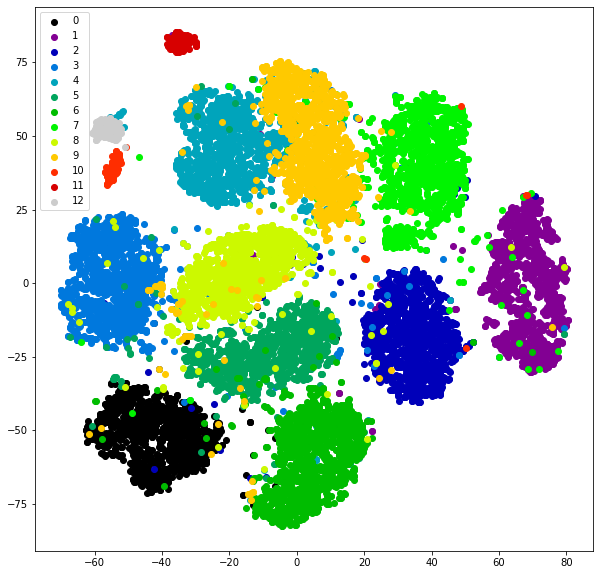

In [52]:
from sklearn.manifold import TSNE
x_t = torch.cat(x_1[:1000])
y_t = torch.cat(y_1[:1000])
recon,mu,logvar = model(x_t.cuda())
z = model.reparameterize(mu,logvar).detach().cpu().numpy()

tsne = TSNE(n_components=2)
tsneArr = tsne.fit_transform(z)

c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(y_t)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(y_t))):
    plt.scatter(tsneArr[y_t==i,0],tsneArr[y_t==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')